In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

In [6]:
def normalize_pixels(data):
    return data / 255

In [7]:
def pred_to_human_readable(one_hot_arr) -> str:
    
    shapes = ["none", "vertical_ellipse","horizontal_ellipse", "heart",  "circle", "hexagon","spiral"] 
    index = np.where(one_hot_arr == max(one_hot_arr))[0][0]
    
    return shapes[index]

In [12]:
def load_dataset():
    data = np.load('dataset/shape_data.npz', mmap_mode='r', allow_pickle=True)
    x = data['contours']
    y = data['labels']
    
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.33, random_state=42)
    
    train_x.reshape(-1, 28,28,1)
    test_x.reshape(-1, 28, 28,1)
    
    train_y = to_categorical(train_y)
    test_y = to_categorical(test_y)
    
    return normalize_pixels(train_x), normalize_pixels(test_x), train_y, test_y

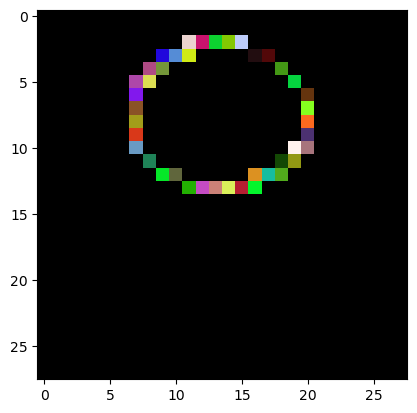

In [13]:
train_x, test_x, train_y, test_y = load_dataset()

isRgb = train_x[0].shape[2] == 3 

width = train_x[0].shape[0]
height = train_x[0].shape[1]

plt.imshow(train_x[1])

In [14]:
channel = 1
if (isRgb):
    channel = 3
IN_SHAPE = (width,height,channel)
NO_OUTS = len(test_y[0])

1. A convolution 2D layer with 32 filter of size 3x3, stride 1, no padding, `he_uniform` kernel initializer and RELU activation function.
2. A max pooling layer with filter 2x2
3. A flatten layer
4. A dense layer with 100 neurons, `he_uniform` kernel initializer and RELU activation function.
5. The output layer

In [15]:
def define_model(layers):
    model = Sequential()
    for i in range(layers):
        model.add(Conv2D(32, (3,3), activation = "relu", kernel_initializer="he_uniform", input_shape =IN_SHAPE ))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(60, activation ="relu", kernel_initializer="he_uniform"))
    model.add(Dense(NO_OUTS, activation ="softmax"))
    
    model.compile(optimizer= SGD(lr = 0.01, momentum = 0.9), loss = "categorical_crossentropy", metrics = ["accuracy"])
    
    return model

In [16]:
define_model(1).summary()

2022-11-17 20:09:26.965604: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 20:09:26.966028: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 60)                324540    
                                                                 
 dense_1 (Dense)             (None, 7)                 427       
                                                                 
Total params: 325,863
Trainable params: 325,863
Non-trainable params: 0
__________________________________________________

/home/dimitris/miniconda3/envs/cs4049/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [17]:
def evaluate_model(k, train_x, train_y):
    scores, hist = [], []
    kf = KFold(k, shuffle = True, random_state= 42)
    
    for model_number, (train_index, test_index) in enumerate(kf.split(train_x)):
        model = define_model(1)
        trainX, trainY, testX, testY = train_x[train_index], train_y[train_index], train_x[test_index], train_y[test_index]
        
        history = model.fit(trainX, trainY, epochs=5, batch_size=32, validation_data = (testX,testY), verbose = 1)
        _, acc = model.evaluate(testX, testY)

        
        print("Acc of model " + str(model_number) + "is " + str(acc))
        if not os.path.exists("weights"):
            os.makedirs("weights")
        model.save_weights("weights/model" + str(model_number) + ".h5")
        scores.append(acc)
        hist.append(history)
    return scores,hist

In [18]:
scores, hist = evaluate_model(2,train_x, train_y)

Epoch 1/5
63/63 [==============================] - 7s 114ms/step - loss: 0.3835 - accuracy: 0.8891 - val_loss: 0.0395 - val_accuracy: 0.9935
Epoch 2/5
63/63 [==============================] - 6s 103ms/step - loss: 0.0280 - accuracy: 0.9940 - val_loss: 0.0137 - val_accuracy: 0.9985
Epoch 3/5
63/63 [==============================] - 7s 120ms/step - loss: 0.0106 - accuracy: 0.9995 - val_loss: 0.0080 - val_accuracy: 0.9990
Epoch 4/5
63/63 [==============================] - 7s 113ms/step - loss: 0.0068 - accuracy: 0.9995 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 5/5
63/63 [==============================] - 2s 31ms/step - loss: 0.0043 - accuracy: 1.0000
Acc of model 0is 1.0
Epoch 1/5
63/63 [==============================] - 7s 108ms/step - loss: 0.3392 - accuracy: 0.9149 - val_loss: 0.0444 - val_accuracy: 0.9915
Epoch 2/5
63/63 [==============================] - 6s 98ms/step - loss: 0.0229 - accuracy: 0.9950 - val_loss: 0.0190 - val_accuracy: 0.9945
Epoch 3/5
63/63 [===================

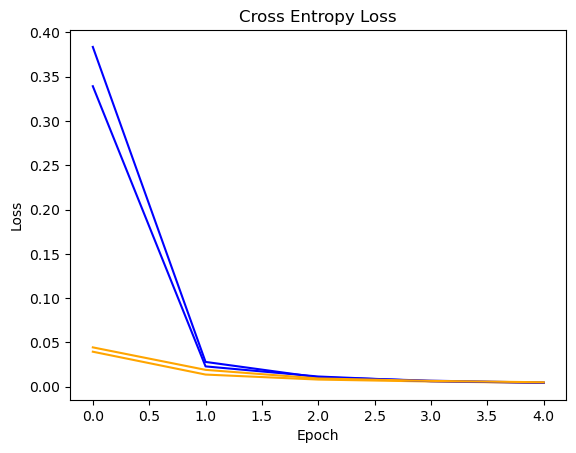

In [19]:
for i in range(len(hist)):
    # plot loss
    plt.title('Cross Entropy Loss')
    plt.plot(hist[i].history['loss'], color='blue', label='train')
    plt.plot(hist[i].history['val_loss'], color='orange', label='test')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
plt.show()


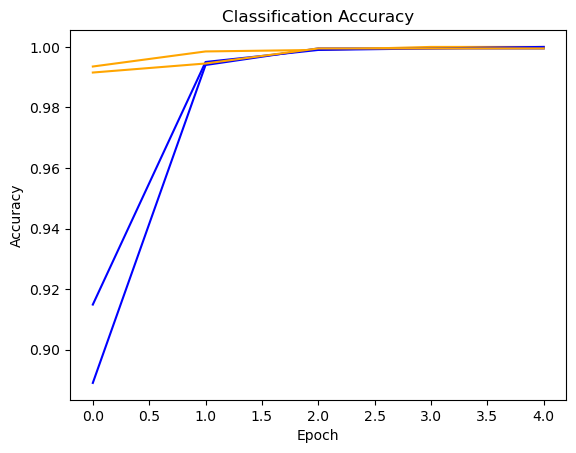

In [20]:
for i in range(len(hist)):
    plt.title('Classification Accuracy')
    plt.plot(hist[i].history['accuracy'], color='blue', label='train')
    plt.plot(hist[i].history['val_accuracy'], color='orange', label='test')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
plt.show()



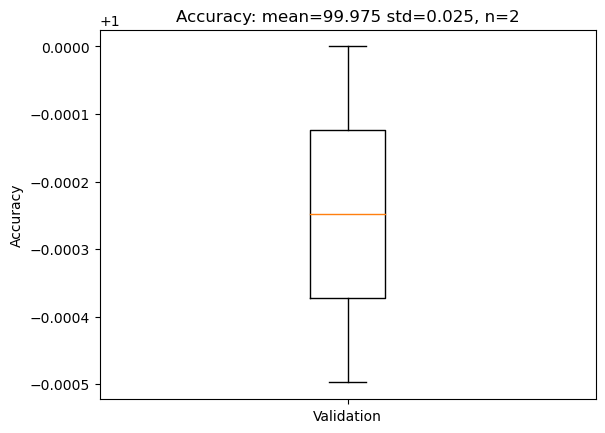

[1.0, 0.9995024800300598]


In [21]:
plt.title('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
# box and whisker plots of results
plt.boxplot(scores)
plt.ylabel("Accuracy")
plt.xticks([1],["Validation"])
plt.show()

print(scores)



In [22]:
best_model = define_model(1)
best_model.load_weights("weights/model"+str(np.argmax(scores))+".h5")
best_model.evaluate(test_x, test_y)

 1/62 [..............................] - ETA: 7s - loss: 0.0029 - accuracy: 1.0000

/home/dimitris/miniconda3/envs/cs4049/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


62/62 [==============================] - 2s 30ms/step - loss: 0.0069 - accuracy: 0.9975


[0.006854088511317968, 0.997474730014801]

In [23]:
test_x[0].shape

(28, 28, 3)

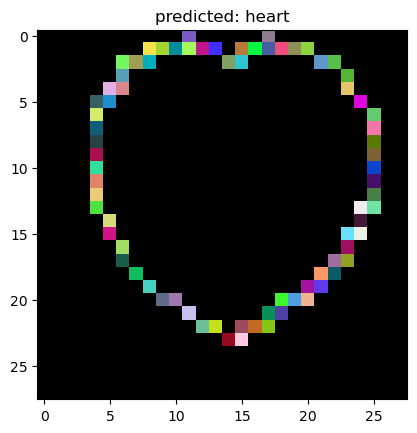

In [35]:
plt.imshow(test_x[3])
plt.title("predicted: " + pred_to_human_readable(predictions[3]))
plt.show()

In [29]:
predictions = best_model.predict(test_x[:11])

pred_to_human_readable(predictions[2])

'vertical_ellipse'

In [86]:
test_y[4]

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [66]:
np.where(predictions[0] == max(predictions[0]))[0][0]

2